## Import necessary modules and data

In [5]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from keras_metrics import precision
from sklearn.model_selection import cross_validate
from livelossplot import PlotLossesKeras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras_metrics import precision
from keras.initializers import glorot_normal
import random



## Wczytujemy zbiór danych

In [6]:
url = 'https://raw.githubusercontent.com/Dalthirr/NeuralNetworks/master/data/Churn_Modelling.csv'

df = pd.read_csv(url)
df = df.drop(["CustomerId", "Surname", "RowNumber"],
             axis=1)
df = pd.concat([df, pd.get_dummies(df[["Gender", "Geography"]], drop_first=True)],
               sort=False, axis=1).drop(df[["Gender", "Geography"]], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
CreditScore          10000 non-null int64
Age                  10000 non-null int64
Tenure               10000 non-null int64
Balance              10000 non-null float64
NumOfProducts        10000 non-null int64
HasCrCard            10000 non-null int64
IsActiveMember       10000 non-null int64
EstimatedSalary      10000 non-null float64
Exited               10000 non-null int64
Gender_Male          10000 non-null uint8
Geography_Germany    10000 non-null uint8
Geography_Spain      10000 non-null uint8
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


## Wyrzucamy zmienną odnośnie posiadania karty kredytowej i stratyfikujemy zbiór tak, żeby wyrównać proporcje etykiet

In [7]:
df = df.drop(["HasCrCard"],
            axis=1)
#empty list for index
random_list = []
for i in range(len(df.values)):
  #sampling from uniform distribution 
  if (df['Exited'].values)[i] == 0 and random.random() > 0.35:
    random_list.append(i)
    
#equalising the subsets
eq_df = df.drop(random_list)
#dropped data
val_df = df.ix[random_list]

/home/seba/.virtualenvs/rl/lib/python3.5/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


## Tworzymy zbiór treningowy i testowy, standaryzujemy i stratyfikujemy odpowiednio do proporcji etykiet

In [8]:
# split into input X and output y variables
X = (eq_df.drop(['Exited'], axis=1)) #dropping exited
y = eq_df.Exited
#splitting data for train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123)
#standardization
scaler = StandardScaler().fit(X_train)
X_train_centered = scaler.transform(X_train)
X_test_centered = scaler.transform(X_test)

/home/seba/.virtualenvs/rl/lib/python3.5/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/seba/.virtualenvs/rl/lib/python3.5/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  
/home/seba/.virtualenvs/rl/lib/python3.5/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


## Sprawdźmy teraz proporcje etykiet w zbiorze

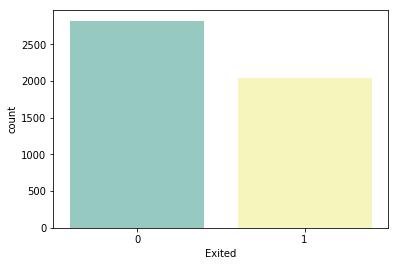

In [9]:
ax = seaborn.countplot(x='Exited', data=eq_df, palette='Set3')
df.loc[:,'Exited'].value_counts()
plt.show()

## Wydają się znacznie bardziej wyrównane niż pierwotnie. Przejdźmy zatem do tworzenia modelu

In [11]:
es = EarlyStopping(monitor='val_precision', mode='max', verbose=1, patience=3)

model_3=Sequential(name='model_3')
# Add an input layer shape depends on shape of X. We have 11 columns in X.
model_3.add(Dense(11, activation='relu', kernel_initializer=glorot_normal(seed=None), input_shape=(10,)))
#glorot initializer  normal, uniform
#X.Glorot, Y.Benjo, Understanding the difficulty of deep feedforward neural networks
# Add one hidden layer 
model_3.add(Dense(36, activation='tanh', kernel_initializer=glorot_normal(seed=None)))


# Add an output layer 
model_3.add(Dense(1, activation='sigmoid'))


model_3.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=[precision(), 'accuracy'])
                 
 
history = model_3.fit(X_train_centered, y_train, validation_split=0.15, 
                      epochs=25, 
                      batch_size=3, verbose=1,
                      callbacks = [es])

tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fp
Train on 3510 samples, validate on 620 samples
Epoch 1/25
3510/3510 [==============================] - 1s 409us/step - loss: 0.6159 - precision: 0.5321 - accuracy: 0.6501 - val_loss: 0.6039 - val_precision: 0.7004 - val_accuracy: 0.6984
Epoch 2/25
3510/3510 [==============================] - 1s 273us/step - loss: 0.5575 - precision: 0.6846 - accuracy: 0.7199 - val_loss: 0.5653 - val_precision: 0.7423 - val_accuracy: 0.7306
Epoch 3/25
3510/3510 [==============================] - 1s 276us/step - loss: 0.5251 - precision: 0.7106 - accuracy: 0.7365 - val_loss: 0.5388 - val_precision: 0.7896 - val_accuracy: 0.7516
Epoch 4/25
3510/3510 [==============================] - 1s 272us/step - loss: 0.4971 - precision: 0.7300 - accuracy: 0.7604 - val_loss: 0.4968 - val_precision: 0.8007 - val_accuracy: 0.7774
Epoch 5/25
3510/3510 [==============================] -

## Stwórzmy wizualizację modelu

In [12]:
# !pip install -q graphviz
# !pip install -q ann_visualizer
# from ann_visualizer.visualize import ann_viz
# ann_viz(model, view=True, filename="model_3")

In [13]:
from IPython.display import IFrame
plot_fn = '../miscellaneous/model.pdf'
IFrame(plot_fn, width=900, height=700)

## Sprawdźmy, jak zmieniała się precyzja i skuteczność modelu na zbiorze treningowym i walidacyjnym w zależności od liczby epok 

In [15]:
history.history

{'accuracy': [0.65014243,
  0.71994305,
  0.73646724,
  0.76039886,
  0.77378917,
  0.777208,
  0.78347576,
  0.785755,
  0.78717947,
  0.78689456,
  0.78689456,
  0.7891738],
 'loss': [0.6159131422320492,
  0.5575138896576359,
  0.5251381386453524,
  0.4971422172541547,
  0.4772940078861693,
  0.46701079869849815,
  0.4603111159852427,
  0.45531890366512995,
  0.45206037008036404,
  0.4499872767103788,
  0.4468307461366694,
  0.4439333391909161],
 'precision': [0.5321332,
  0.684649,
  0.710646,
  0.73001635,
  0.7579018,
  0.7754854,
  0.76220673,
  0.7655481,
  0.76425403,
  0.77846116,
  0.7677109,
  0.7794343],
 'val_accuracy': [0.698387086391449,
  0.7306451797485352,
  0.7516129016876221,
  0.7774193286895752,
  0.7822580933570862,
  0.7838709950447083,
  0.774193525314331,
  0.7693548202514648,
  0.7806451320648193,
  0.7774193286895752,
  0.7790322303771973,
  0.774193525314331],
 'val_loss': [0.6039330175206545,
  0.5653320340139251,
  0.5388153757299147,
  0.496796354086649,

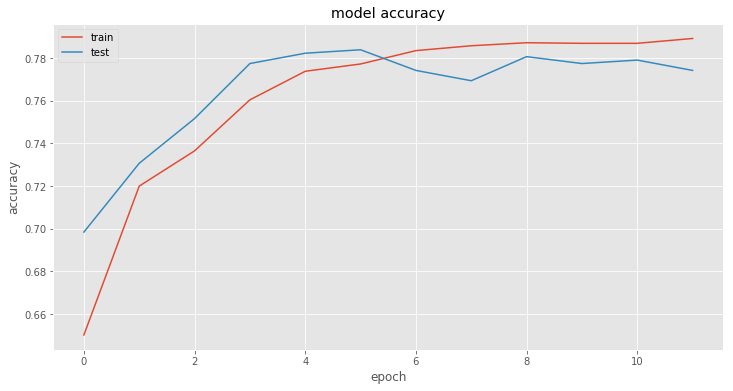

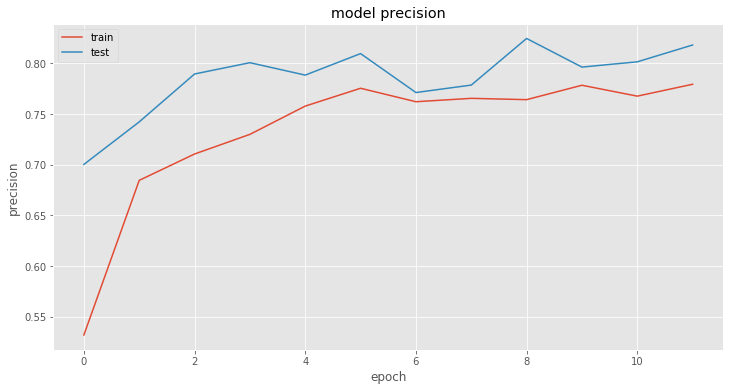

In [16]:
plt.style.use('ggplot')
plt.figure(figsize = (12,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.figure(figsize = (12,6))
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

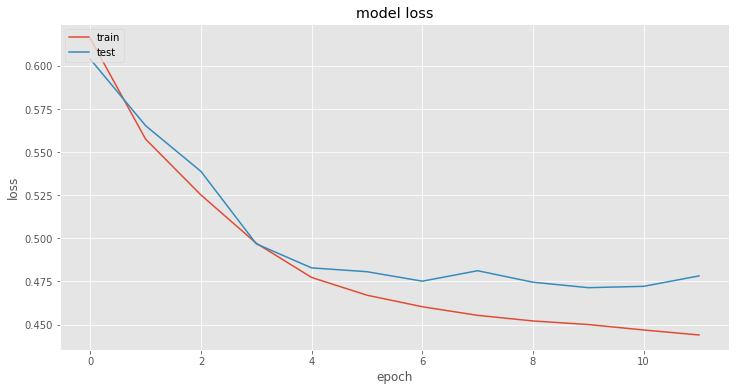

In [17]:
plt.style.use('ggplot')
plt.figure(figsize = (12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Metryki wydajności modelu

**Macierz pomyłek**

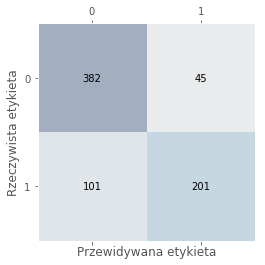

In [18]:
y_pred = model_3.predict_classes(X_test_centered)
confmat = confusion_matrix(y_test,y_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=.3)
plt.grid()
for i in range(confmat.shape[0]):
  for j in range(confmat.shape[1]):
    ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    
plt.xlabel('Przewidywana etykieta')
plt.ylabel('Rzeczywista etykieta')
plt.show()

In [19]:
FP = confmat[1][0]   #false positive
TP = confmat[1][1]   #true positive
TN = confmat[0][0]   #true negative
FN = confmat[0][1]   #false negative

error = (FP+FN)/(FP+FN+TP+TN)*100
acc = (TP+TN)/(FP+FN+TP+TN)*100

ofp = FP/(FP+TN)*100   #true positive rate
opp = TP/(FN+TP)*100   #false positive rate

pre = TP/(TP+FP)*100   #precision
recall = TP/(FN+TP)*100 #recall (pełność)

print("Błąd %f%% " % error)
print("Dokładność %f%% " % acc)
print("Precision %f%% " % pre)
print("Recall %f%% " % recall)
print("True positive rate %f%% " % ofp)
print("False positive rate %f%% " % opp)

Błąd 20.027435% 
Dokładność 79.972565% 
Precision 66.556291% 
Recall 81.707317% 
True positive rate 20.910973% 
False positive rate 81.707317% 


**Rejected samples**

In [20]:
val_df = df.ix[random_list]
# split into input X and output y variables
X_val = (val_df.drop(['Exited'], axis = 1)) #dropping exited
y_val = val_df.Exited
#standardization
scaler=StandardScaler().fit(X_val)
X_val_centered = scaler.transform(X_val)
y_vpred = model_3.predict_classes(X_val_centered)
val_confmat = confusion_matrix(y_val,y_vpred)
val_FP = val_confmat[1][0]   #false positive
val_TP = val_confmat[1][1]   #true positive
val_TN = val_confmat[0][0]   #true negative
val_FN = val_confmat[0][1]   #false negative
val_error = (val_FP+val_FN)/(val_FP+val_FN+val_TP+val_TN)*100
val_acc = (val_TP+val_TN)/(val_FP+val_FN+val_TP+val_TN)*100
print("Ilość próbek %f, Poprawnie sklasyfikowane %f" %(int(len(y_val)), int(val_confmat[0][0])))
print("Błąd %f%% " % val_error)
print("Dokładność %f%% " % val_acc)

Ilość próbek 5141.000000, Poprawnie sklasyfikowane 3599.000000
Błąd 29.994165% 
Dokładność 70.005835% 


/home/seba/.virtualenvs/rl/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/home/seba/.virtualenvs/rl/lib/python3.5/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/seba/.virtualenvs/rl/lib/python3.5/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  import sys


## Zapisujemy wytrenowany model

In [21]:
model_3.save('../saved_models/model_3.h5')

### autor: Karolina Schmidt i Patrycja Studzienna